In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import re
from os import path
from glob import glob
from tqdm import tqdm
import numpy as np
from matplotlib import cm
from pprint import pprint
from plotting_utils import get_legend_name, remove_outliers

In [153]:
ROOT_PATH = '\\\\CILab_NAS_Data/homes/inchang/PuzzlePCG/ProxyPlayer'

In [154]:
files = glob(path.join(ROOT_PATH, '*', 'MatchResult_*.csv'))


In [155]:
StatisticsColumns = [
    'ReachedKnowledgeStep',
    'Matched_HorizontalPiece', 'Matched_VerticalPiece', 'Matched_CrossPiece', 'Matched_RocketPiece', 'Matched_BombPiece', 'Matched_RainbowPiece']

In [156]:
replacements = {
    'met': 'method',
    'pla': 'player',
    'eff': 'simpleEffect',
    'obj': 'objective',
    'sim': 'simulation',
    'rat': 'almostRatio',
    'pdep': 'playerDepth',
}

def parse_filename(data):
    result = dict()
    for i in range(0, len(data), 2):
        if data[i] in replacements.keys():
            data[i] = replacements[data[i]]

        result[data[i]] = data[i+1]

    return result

In [157]:
dfs = []
for file_path in tqdm(files):
    # print(file_path)
    file_name = path.basename(file_path)

    _file_name = file_name.split('_')[1:-1]
    args = parse_filename(_file_name)

    df = pd.read_csv(file_path)

    for key, value in args.items():
        df[key] = value
    dfs.append(df)

original_df = pd.concat(dfs)

original_df['Sum_Matched'] = original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece']  + \
    original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece'] + original_df['Matched_HorizontalPiece']
original_df.loc[original_df['method'] == 'random', 'simulation'] = 0

original_df['simpleEffect'] = original_df['simpleEffect'].replace(np.nan, 0)
original_df['objective'] = original_df['objective'].replace(np.nan, '-')

original_df.loc[original_df['method'] == 'random', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'sampling', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'ga', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'ga2', 'playerDepth'] = '-'
original_df.loc[original_df['method'] == 'random', 'simulation'] = '-'
original_df.loc[original_df['method'] == 'ga', 'simulation'] = '-'
original_df.loc[original_df['method'] == 'ga2', 'simulation'] = '-'
# original_df.loc[original_df['method'] == 'sampling', 'simulation'] = '-'
original_df.loc[original_df['method'] == 'random', 'almostRatio'] = '-'
original_df.loc[original_df['method'] == 'sampling', 'almostRatio'] = '-'
original_df.loc[original_df['method'] == 'ga', 'almostRatio'] = '-'
original_df.loc[original_df['objective'] == 'kp', 'almostRatio'] = '-'
original_df.loc[original_df['objective'] == 'score', 'almostRatio'] = '-'

100%|██████████| 18/18 [00:00<00:00, 19.54it/s]


In [158]:
# 완료하지 못했을 경우, 에피소드 최대길이로 설정
original_df['ReachedKnowledgeStep'] = original_df['ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q1ReachedKnowledgeStep'] = original_df['Q1ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q2ReachedKnowledgeStep'] = original_df['Q2ReachedKnowledgeStep'].replace(-1, 200)
original_df['Q3ReachedKnowledgeStep'] = original_df['Q3ReachedKnowledgeStep'].replace(-1, 200)


In [159]:
for i in range(5):
    original_df['playerDepth'] = original_df['playerDepth'].replace(str(i), i)
for i in range(100, 1000, 100):
    original_df['simulation'] = original_df['simulation'].replace(str(i), i)

In [160]:
match_result = original_df.groupby(['method', 'objective', 'playerDepth', 'simulation'])[
                                      'method',
                                      'Matched_HorizontalPiece',
                                      'Matched_VerticalPiece',
                                      'Matched_CrossPiece',
                                      'Matched_RocketPiece',
                                      'Matched_BombPiece',
                                      'Matched_RainbowPiece',
                                      #'AlmostReachedKnowledgeStep',
                                      'Q1ReachedKnowledgeStep',
                                      'Q2ReachedKnowledgeStep',
                                      'Q3ReachedKnowledgeStep',
                                      'ReachedKnowledgeStep',
                                      'Sum_Matched'].agg(
    {
        'method': ['count'],
     }
)
match_result




C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


method
                                         count
method objective playerDepth simulation       
mcts   knowledge 1           200          3000
       score     1           200          3000
random -         -           -            3000

### Full Result

In [161]:
# Drop outliers
match_result = original_df.copy()

match_result = match_result[~match_result['almostRatio'].isin(['0.75'])]
# match_result = match_result[~match_result['playerDepth'].isin([2])]
# match_result = match_result[~match_result['simulation'].isin([100, 400])]



columns_to_remove_outliers = ['Q1ReachedKnowledgeStep',
                              'Q2ReachedKnowledgeStep',
                              'Q3ReachedKnowledgeStep',
                              'ReachedKnowledgeStep']

for column in columns_to_remove_outliers:
    match_result[column] = match_result.groupby(['method', 'simpleEffect', 'objective', 'playerDepth', 'simulation'])[column].transform(remove_outliers)
    match_result = match_result[match_result[column] != -9999]

match_result_noout = match_result.copy()

# print(set(match_result['playerDepth']))
# pd.set_option('display.max_rows', None)
match_result = match_result.groupby(['method', 'simpleEffect','objective', 'playerDepth', 'simulation'])[
                                      'method',
                                      'Matched_HorizontalPiece',
                                      'Matched_VerticalPiece',
                                      'Matched_CrossPiece',
                                      'Matched_RocketPiece',
                                      'Matched_BombPiece',
                                      'Matched_RainbowPiece',
                                      'Q1ReachedKnowledgeStep',
                                      'Q2ReachedKnowledgeStep',
                                      'Q3ReachedKnowledgeStep',
                                      'ReachedKnowledgeStep',
                                      'Sum_Matched'].agg(
    {
        'method': ['count']
     }
)
match_result


C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


method
                                                      count
method simpleEffect objective playerDepth simulation       
mcts   1            knowledge 1           200          3000
                    score     1           200          3000
random 1            -         -           -            2984

### Depth 1 Result

In [162]:
# Drop outliers
match_result = original_df.copy()

# match_result = match_result[~match_result['almostRatio'].isin(['0.75'])]
# match_result = match_result[~match_result['playerDepth'].isin([2, 3])]
# match_result = match_result[~match_result['objective'].isin([2, 3])]
# match_result = match_result[~match_result['simulation'].isin([200])]


columns_to_remove_outliers = ['Q1ReachedKnowledgeStep',
                              'Q2ReachedKnowledgeStep',
                              'Q3ReachedKnowledgeStep',
                              'ReachedKnowledgeStep']

for column in columns_to_remove_outliers:
    match_result[column] = match_result.groupby(['player', 'method', 'simpleEffect', 'objective', 'playerDepth', 'simulation'])[column].transform(remove_outliers)
    match_result = match_result[match_result[column] != -9999]


# print(set(match_result['playerDepth']))
# pd.set_option('display.max_rows', None)

match_result.rename(columns={
                            'ReachedKnowledgeStep': '100%',
                            'Q1ReachedKnowledgeStep': '25%',
                            'Q2ReachedKnowledgeStep': '50%',
                            'Q3ReachedKnowledgeStep': '75%'
                            }, inplace=True)

pd.set_option('display.max_rows', None)

match_result = match_result.groupby(['method', 'objective', 'simulation'])[
                                      '25%',
                                      '50%',
                                      '75%',
                                      '100%',
                                      'Sum_Matched'].agg(
    {
        'Sum_Matched': ['mean',],
        '25%': ['mean'],
        '50%': ['mean'],
        '75%': ['mean'],
        '100%': ['mean'],
     }
)
match_result

C:\Users\GIST\.conda\envs\mlagents\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Sum_Matched         25%         50%         75%  \
                                   mean        mean        mean        mean   
method objective simulation                                                   
mcts   knowledge 200         173.431537   71.121861   86.497489  110.382658   
       score     200         207.696000   83.786333  102.367000  129.580000   
random -         -           148.240268  111.724832  133.116779  159.898658   

                                   100%  
                                   mean  
method objective simulation              
mcts   knowledge 200         121.681286  
       score     200         140.756667  
random -         -           168.374832

In [163]:
match_result.to_latex('match_count_table.tex', float_format="%.3f", escape=True)


In [164]:
display_graphs = ['random', 'ga',
                  'sampling_20',
                   'mcts_knowledge_1.0_1000_1',
                   'mcts_score_1000_1']

{'random', 'mcts_score_200_1', 'mcts_knowledge_1.0_200_1'}


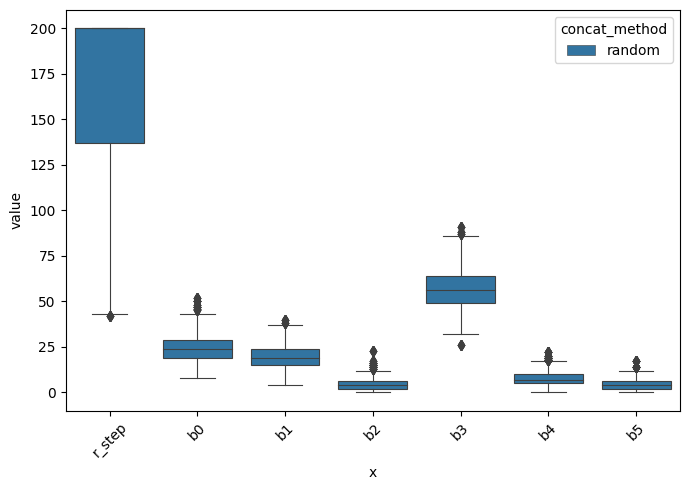

In [165]:
melted_df = match_result_noout.copy()

melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
pprint(set(melted_df['concat_method']))
# Display Target
melted_df = melted_df[melted_df['concat_method'].isin(['random', 'ga',
                                                       'sampling_20',
                                                       'mcts_knowledge_1.0_1000_1',
                                                       'mcts_score_1000_1'])]

plt.figure(figsize=(7, 5))
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'],
                    value_vars=[*StatisticsColumns], ignore_index=False)

melted_df['x'] = melted_df['variable']
melted_df['x'] = melted_df['x'].str.replace('ReachedKnowledgeStep', 'r_step')
melted_df['x'] = melted_df['x'].str.replace('Matched_HorizontalPiece', 'b0')
melted_df['x'] = melted_df['x'].str.replace('Matched_VerticalPiece', 'b1')
melted_df['x'] = melted_df['x'].str.replace('Matched_CrossPiece', 'b2')
melted_df['x'] = melted_df['x'].str.replace('Matched_RocketPiece', 'b3')
melted_df['x'] = melted_df['x'].str.replace('Matched_BombPiece', 'b4')
melted_df['x'] = melted_df['x'].str.replace('Matched_RainbowPiece', 'b5')

ax = sns.boxplot(x="x", y="value", hue="concat_method", data=melted_df, linewidth=0.8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('matched_block.png')

In [166]:
from statannot import add_stat_annotation
from itertools import combinations

In [167]:
player_df = match_result_noout[match_result_noout['player'] == str(player_no)]
melted_df = player_df.copy()

melted_df.rename(columns={
    'ReachedKnowledgeStep':'100',
    'Q1ReachedKnowledgeStep':'25',
    'Q2ReachedKnowledgeStep':'50',
    'Q3ReachedKnowledgeStep':'75'
}, inplace=True)

_columns = ['25', '50', '75', '100']

sns.set_palette('Set2')
# melted_df = melted_df.groupby(['player', 'method', 'objective', 'playerDepth', 'simulation']).sample(n=300, random_state=1)
melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'], value_vars=[*_columns], ignore_index=False)

melted_df = melted_df[melted_df['concat_method'].isin(display_graphs)]

plt.figure(figsize=(7, 4))
plt.clf()
ax = sns.boxplot(x="variable", y="value", hue="concat_method", data=melted_df, dodge=True, linewidth=0.8)

pairs = list()
for i in range(25, 101, 25):
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'random')))
    pairs.append(((str(i), 'random'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'random'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_score_1000_1'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'sampling_20')))

add_stat_annotation(ax, x="variable", y="value", hue="concat_method", data=melted_df,
                    box_pairs=pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=1)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax.set_title(f'Required Steps for Learning Skill (Player: {player_no})')
ax.set_xlabel('Progress (%)')
ax.set_ylabel('Step')
plt.tight_layout()
plt.savefig(f'./figures/learning_steps_p{player_no}', dpi=300)
    # plt.show()

NameError: name 'player_no' is not defined

In [ ]:

melted_df = match_result_noout.copy()

melted_df.rename(columns={
    'ReachedKnowledgeStep':'100',
    'Q1ReachedKnowledgeStep':'25',
    'Q2ReachedKnowledgeStep':'50',
    'Q3ReachedKnowledgeStep':'75'
}, inplace=True)

_columns = ['25', '50', '75', '100']

sns.set_palette('Set3')
# melted_df = melted_df.groupby(['player', 'method', 'objective', 'playerDepth', 'simulation']).sample(n=300, random_state=1)
melted_df['concat_method'] = melted_df.agg(lambda x: get_legend_name(x), axis=1)
melted_df = pd.melt(melted_df, id_vars=['EpisodeCount', 'objective', 'concat_method', 'simulation', 'player'], value_vars=[*_columns], ignore_index=False)

melted_df = melted_df[melted_df['concat_method'].isin(display_graphs)]


plt.figure(figsize=(7, 4))
plt.clf()
ax = sns.boxplot(x="variable", y="value", hue="concat_method", data=melted_df, dodge=True, linewidth=0.8)

pairs = list()
for i in range(25, 101, 25):
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'random')))
    pairs.append(((str(i), 'random'), (str(i), 'mcts_score_1000_1')))
    pairs.append(((str(i), 'random'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_score_1000_1'), (str(i), 'sampling_20')))
    pairs.append(((str(i), 'mcts_knowledge_1.0_1000_1'), (str(i), 'sampling_20')))

add_stat_annotation(ax, x="variable", y="value", hue="concat_method", data=melted_df,
                    box_pairs=pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=1)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
ax.set_title(f'Required Steps for Learning Skill (Player: All)')
ax.set_xlabel('Progress (%)')
ax.set_ylabel('Step')
plt.savefig(f'./figures/learning_steps_pA', dpi=300)
# plt.show()